# Mapas de Vulnerabilidad COVID-19*
## Lima Metropolitana, Perú

### Objetivo

Desarrollar una plataforma de visualización de datos geograficos que soporte la toma de decisiones de instituciones publicas con el objetivo de mitigar los impactos de la crisis del COVID-19.

Los mapas deben estar basados en datos abiertos y replicables a otras ciudados, de modo que permita identificar rápidamente las zonas con una alta concentración de población vulnerable considerando las siguientes dimensiones: accesibilidad vial, nivel socioeconómico, grupo etario, población flotante, densidad poblacional, fuerza laboral, y acceso a servicios básicos.

### Fuentes de datos

- **Nominatim OpenStreetMap**
- **Overpass OpenStreetMap**
- **Censo Nacional 2007 INEI**


*Este notebook esta basado en [el trabajo de Patricio y Tony para la ciudad de Quito](https://vulnerabilidad-codigo.netlify.com/)

### Dependencias

In [1]:
import geopandas as gpd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import shapely
import json
import pandas as pd
import plotly.graph_objects as go
import pydeck as pdk
import requests
from h3 import h3
from scipy.spatial import cKDTree
from tqdm import tqdm

# Notebook setup
%matplotlib inline
sns.set_style('dark')
tqdm.pandas()

/Users/cortega/Documents/COVID-19/VulnerabilityMaps_LimaLab_BID/.env/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



## Descarga de datos

### Límites de la ciudad

El primer paso será conseguir los limites de la ciudad, para Lima Metropolitana se deben combinar los limites de Lima y Callao. Fuente: [Nominatim](https://nominatim.openstreetmap.org/)

In [2]:
# Fuente de datos
url = 'https://nominatim.openstreetmap.org/search.php'
parameters = {
    'polygon_geojson': '1',
    'format': 'geojson'
}

In [3]:
# Descarga de datos de Lima
posicion = 2 # La posición en que aparece entre los resultados de Nominatim 
parameters['q'] = "Lima, Peru"

response = requests.get(url, params=parameters)
all_results = response.json()
lima_gdf = gpd.GeoDataFrame.from_features(all_results['features'])
lima_ = lima_gdf.iloc[posicion:posicion+1, :] # Limites de Lima provincia

In [4]:
# Descarga de datos de Lima
parameters['q'] = "Callao, Peru"
posicion = 1 # La posición en que aparece entre los resultados de Nominatim 

response = requests.get(url, params=parameters)
all_results = response.json()
callao_gdf = gpd.GeoDataFrame.from_features(all_results['features'])
callao_ =  callao_gdf.iloc[posicion:posicion+1, :] # Limites de Callao provincia constitucional

In [5]:
# Combinacion de limites de lima y callao
lima_metropolitana = gpd.GeoDataFrame(geometry=[pd.concat((lima_, callao_)).unary_union])

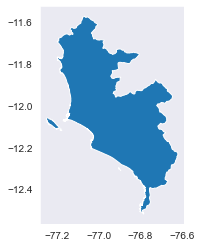

In [6]:
# Visualizamos los datos
lima_metropolitana.plot()
plt.show()

### Estimados de densidad poblacional y demografia

Descargaremos los datos de la web de Humanitarian Data Exchange. Fuente: Peru: [High Resolution Population Density Maps + Demographic Estimates, Facebook](https://data.humdata.org/dataset/peru-high-resolution-population-density-maps-demographic-estimates)

#### Población Total

In [7]:
%%sh
curl -L 'https://data.humdata.org/dataset/4e74db39-87f1-4383-9255-eaf8ebceb0c9/resource/317f1c39-8417-4bde-a076-99bd37feefce/download/population_per_2018-10-01.csv.zip' > 'inputs/population_per_2018-10-01.csv.zip'
unzip -u 'inputs/population_per_2018-10-01.csv' -d 'inputs'

Archive:  inputs/population_per_2018-10-01.csv
Archive:  inputs/population_per_2018-10-01.csv.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26237  100 26237    0     0   9028      0  0:00:02  0:00:02 --:--:--  9025
100 19.3M  100 19.3M    0     0  1545k      0  0:00:12  0:00:12 --:--:-- 2436k
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.


In [8]:
# Leer los datos descargados
population_peru = pd.read_csv('inputs/population_per_2018-10-01.csv')

In [9]:
population_peru.head()

latitude  longitude  population_2015  population_2020
0 -18.339306 -70.382361        11.318147        12.099885
1 -18.335694 -70.393750        11.318147        12.099885
2 -18.335694 -70.387361        11.318147        12.099885
3 -18.335417 -70.394028        11.318147        12.099885
4 -18.335139 -70.394306        11.318147        12.099885

Debemos obtener los limites de la ciudad para filtrar los datos poblacionales de Perú.

In [10]:
minx, miny, maxx, maxy = lima_metropolitana.geometry.total_bounds
limits_filter = population_peru['longitude'].between(minx, maxx) & population_peru['latitude'].between(miny, maxy)
population_lima = population_peru[limits_filter]

# Creamos un GeoDataFrame
geometry_ = gpd.points_from_xy(population_lima['longitude'], population_lima['latitude'])
population_lima_gdf = gpd.GeoDataFrame(population_lima, geometry=geometry_, crs='EPSG:4326')

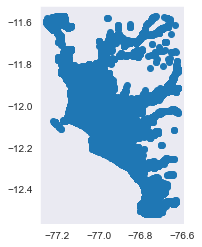

In [11]:
# Visualizamos los puntos obtenidos
population_lima_gdf.plot()
plt.show()

Debemos verificar los datos registrados en la [Isla San Lorenzo](https://es.wikipedia.org/wiki/Isla_San_Lorenzo_(Per%C3%BA)) (frente a las costas del Callao), ya que esta zona es de accesso prohibido y no tiene población permanente.

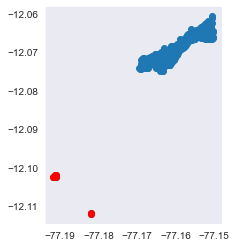

In [12]:
# Isla y la punta
isla_sl = population_lima_gdf['latitude'].between(-12.2,-12) & population_lima_gdf['longitude'].between(-77.2,-77.15)

# Solo isla
isla_sl_red = population_lima_gdf['latitude'].between(-12.2,-12) & population_lima_gdf['longitude'].between(-77.2,-77.17)

# Visualizar para validar
ax = population_lima_gdf[isla_sl].plot()
population_lima_gdf[isla_sl_red].plot(ax=ax, color='red')

In [13]:
# Revisamos los valores poblacionales
population_lima_gdf[isla_sl_red]

latitude  longitude  population_2015  population_2020  \
1465826 -12.112083 -77.182083      8060.376804      7979.752438   
1466130 -12.111806 -77.182083      8060.376804      7979.752438   
1476024 -12.102361 -77.191806      8060.376804      7979.752438   
1476025 -12.102361 -77.191250      8060.376804      7979.752438   
1476026 -12.102361 -77.190972      8060.376804      7979.752438   
1476338 -12.102083 -77.191250      8060.376804      7979.752438   
1476339 -12.102083 -77.190972      8060.376804      7979.752438   

                            geometry  
1465826  POINT (-77.18208 -12.11208)  
1466130  POINT (-77.18208 -12.11181)  
1476024  POINT (-77.19181 -12.10236)  
1476025  POINT (-77.19125 -12.10236)  
1476026  POINT (-77.19097 -12.10236)  
1476338  POINT (-77.19125 -12.10208)  
1476339  POINT (-77.19097 -12.10208)

In [14]:
# Eliminaremos los puntos rojos que corresponden a la isla
drop_ix = population_lima_gdf[isla_sl_red].index
print(population_lima_gdf.shape)
population_lima_gdf = population_lima_gdf.drop(drop_ix)
print(population_lima_gdf.shape)

(348434, 5)
(348427, 5)


#### Población mayor de 60 años

Ahora descargaremos los datos poblaciones de personas mayores a 60 años de la misma fuente

In [15]:
%%sh
curl -L 'https://data.humdata.org/dataset/4e74db39-87f1-4383-9255-eaf8ebceb0c9/resource/8cc100cf-68a4-4fda-a8e6-a63b99ad5b00/download/per_elderly_60_plus_2019-06-01_csv.zip' > 'inputs/per_elderly_60_plus_2019-06-01_csv.zip'
unzip -u 'inputs/per_elderly_60_plus_2019-06-01_csv' -d 'inputs'

Archive:  inputs/per_elderly_60_plus_2019-06-01_csv.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26247  100 26247    0     0   7448      0  0:00:03  0:00:03 --:--:--  7445
100 16.5M  100 16.5M    0     0  1368k      0  0:00:12  0:00:12 --:--:-- 2349k


In [16]:
# Leer los datos descargados
population_over_60_peru = pd.read_csv('inputs/per_elderly_60_plus_2019-06-01.csv')

In [17]:
# Filtrar los datos
limits_filter = population_over_60_peru['longitude'].between(minx, maxx) & population_over_60_peru['latitude'].between(miny, maxy)
population_over_60_lima = population_over_60_peru[limits_filter]

# Creamos un GeoDataFrame
geometry_ = gpd.points_from_xy(population_over_60_lima['longitude'], population_over_60_lima['latitude'])
population_over_60_lima_gdf = gpd.GeoDataFrame(population_over_60_lima, geometry=geometry_, crs='EPSG:4326')

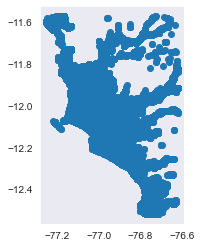

In [18]:
# Visualizamos los puntos obtenidos
population_over_60_lima_gdf.plot()
plt.show()

Debemos verificar los datos registrados en la [Isla San Lorenzo](https://es.wikipedia.org/wiki/Isla_San_Lorenzo_(Per%C3%BA)) (frente a las costas del Callao), ya que esta zona es de accesso prohibido y no tiene población permanente.

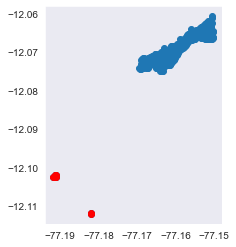

In [19]:
# Isla y la punta
isla_sl = population_over_60_lima_gdf['latitude'].between(-12.2,-12) & population_over_60_lima_gdf['longitude'].between(-77.2,-77.15)

# Solo isla
isla_sl_red = population_over_60_lima_gdf['latitude'].between(-12.2,-12) & population_over_60_lima_gdf['longitude'].between(-77.2,-77.17)

# Visualizar para validar
ax = population_over_60_lima_gdf[isla_sl].plot()
population_over_60_lima_gdf[isla_sl_red].plot(ax=ax, color='red')

In [20]:
# Revisamos los valores poblacionales
population_over_60_lima_gdf[isla_sl_red]

latitude  longitude  population                     geometry
2846981 -12.102361 -77.190972  779.640623  POINT (-77.19097 -12.10236)
2846987 -12.111806 -77.182083  779.640623  POINT (-77.18208 -12.11181)
2846993 -12.102083 -77.190972  779.640623  POINT (-77.19097 -12.10208)
2846994 -12.102083 -77.191250  779.640623  POINT (-77.19125 -12.10208)
2846995 -12.102361 -77.191806  779.640623  POINT (-77.19181 -12.10236)
2847001 -12.112083 -77.182083  779.640623  POINT (-77.18208 -12.11208)
2847011 -12.102361 -77.191250  779.640623  POINT (-77.19125 -12.10236)

In [21]:
# Eliminaremos los puntos rojos que corresponden a la isla
drop_ix = population_over_60_lima_gdf[isla_sl_red].index
print(population_over_60_lima_gdf.shape)
population_over_60_lima_gdf = population_over_60_lima_gdf.drop(drop_ix)
print(population_over_60_lima_gdf.shape)

(348434, 4)
(348427, 4)


### Nivel Socioeconómico y Población por manzana, Fuente: Censo Nacional 2007 INEI

In [22]:
# Cargamos los datos
manzanas = gpd.read_file('inputs/manzanas_nse/mz_lima_region.shp')
manzanas.head()

IDMANZANA CODZONA CODMZNA  CLASIFICAC  UBIGEO NOMBREMZNA  \
0    150728    None    None           1  150728       None   
1    150728    None    None           1  150728       None   
2    150728    None    None           1  150728       None   
3    150728    None    None           1  150728       None   
4    150728    None    None           1  150728       None   

                          URBANIZACI NSE07  POB07  VIV07  LONGITUDE  \
0                               None  None      0      0 -76.671052   
1  ASOC PUEBLO NUEVO DE BUENOS AIRES  None      0      0 -76.672482   
2  ASOC PUEBLO NUEVO DE BUENOS AIRES  None      0      0 -76.673467   
3  ASOC PUEBLO NUEVO DE BUENOS AIRES  None      0      0 -76.673106   
4  ASOC PUEBLO NUEVO DE BUENOS AIRES  None      0      0 -76.672936   

    LATITUDE                                           geometry  
0 -11.916842  POLYGON ((-76.67379 -11.91608, -76.67329 -11.9...  
1 -11.914053  POLYGON ((-76.67319 -11.91445, -76.67318 -11.9...  
2 -11.914446  POLYGON ((-76.67368 -11.91441, -76.67341 -11.9...  
3 -11.914645  POLYGON ((-76.67351 -11.91473, -76.67321 -11.9...  
4 -11.914838  POLYGON ((-76.67335 -11.91492, -76.67267 -11.9...

In [23]:
# Proporcion de valores perdidos por variable
manzanas.isna().sum() / manzanas.shape[0]

IDMANZANA     0.000000
CODZONA       0.181153
CODMZNA       0.181124
CLASIFICAC    0.000000
UBIGEO        0.000000
NOMBREMZNA    0.557573
URBANIZACI    0.230322
NSE07         0.386055
POB07         0.000000
VIV07         0.000000
LONGITUDE     0.000000
LATITUDE      0.000000
geometry      0.000000
dtype: float64

Veamos el número de manzanas por nivel socioeconomico (NSE).

Leyenda:
- AL: Alto
- MA: Medio Alto
- ME: Medio
- MB: Medio Bajo
- BA: Bajo

In [24]:
manzanas['NSE07'].value_counts()

MB    22214
ME    17522
BA     9426
MA     7957
AL     2939
0.     2325
Name: NSE07, dtype: int64

Además de un 38% de valores perdidos para las manzanas, tenemos una categoria **0.** que, a lo mejor de nuestro conocimiento, no tiene descripción. 

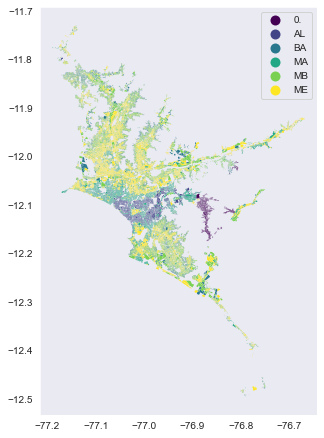

In [25]:
# Distribución espacial de los niveles socioeconómicos
manzanas.plot(column='NSE07', cmap='viridis', linewidth=0, legend=True, figsize=(5, 7.5))
plt.show()

### Instalaciones de oferta de alimentos

In [26]:
# Límites de la ciudad como parámetro para la API Overpass
bbox_string = f'{minx},{miny},{maxx},{maxy}'

# Definir consulta para instalaciones de oferta de alimentos en Lima
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = f"""
[timeout:120][out:json][bbox];
(
  node["amenity"="market_place"];
  node["shop"~"supermarket|kiosk|mall|convenience|butcher|greengrocer"];
);
out body geom;
"""

# Request data
response = requests.get(overpass_url, params={'data': overpass_query,
                                              'bbox': bbox_string})
data = response.json()

In [27]:
# Crea un GeoDataFrame con los datos descargados
food_access_pois_df = pd.DataFrame.from_dict(data['elements'])
food_access_pois_geometry = gpd.points_from_xy(food_access_pois_df['lon'], food_access_pois_df['lat'])
food_access_pois_gdf = gpd.GeoDataFrame(food_access_pois_df, geometry=food_access_pois_geometry)

food access pois: 1910


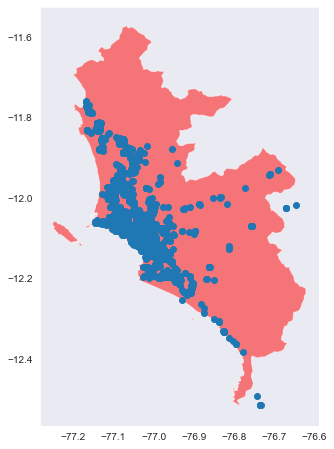

In [28]:
# Visualizar los datos para verificarlos
print('food access pois:', food_access_pois_gdf.shape[0])
ax = lima_metropolitana.plot(color='red', alpha=0.5, figsize=(5,75))
food_access_pois_gdf.plot(ax=ax)
plt.show()

### Sitios de salud

In [29]:
# Definir consulta para los sitios de salud en Lima
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = f"""
[timeout:120][out:json][bbox];
(
  node["amenity"~"clinic|hospital"];
);
out body geom;
"""

# Request data
response = requests.get(overpass_url, params={'data': overpass_query,
                                              'bbox': bbox_string})
data = response.json()

In [30]:
# Crea un GeoDataFrame con los datos descargados
health_sites_pois_df = pd.DataFrame.from_dict(data['elements'])
health_sites_pois_geometry = gpd.points_from_xy(health_sites_pois_df['lon'], health_sites_pois_df['lat'])

health_sites_gdf = gpd.GeoDataFrame(health_sites_pois_df, geometry=health_sites_pois_geometry)

Health sites: 316


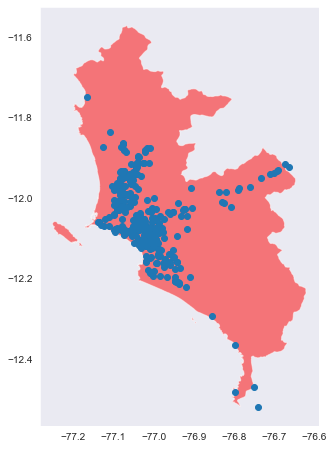

In [31]:
# Visualizar los daots para verificarlos
print('Health sites:', health_sites_gdf.shape[0])
ax = lima_metropolitana.plot(color='red', alpha=0.5, figsize=(5,75))
health_sites_gdf.plot(ax=ax)
plt.show()

### Parques y lozas deportivas

In [32]:
# Definir consulta para los sitios de salud en Lima
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = f"""
[timeout:120][out:json][bbox];
(
  way["leisure"~"park|pitch"];
  node["leisure"="pitch"];
);
out body geom;
"""

# Request data
response = requests.get(overpass_url, params={'data': overpass_query,
                                              'bbox': bbox_string})
data = response.json()

In [33]:
def shell_from_geometry(geometry):
    shell = []
    for record in geometry:
        shell.append([record['lon'], record['lat']])
    return shell

In [34]:
# Crea un GeoDataFrame con los datos descargados
leisure_pois_df = pd.DataFrame.from_dict(data['elements'])

# Procesa los datos de tipo node (puntos)
leisure_nodes = leisure_pois_df[leisure_pois_df['type'] == 'node'].drop(['bounds', 'nodes', 'geometry'], axis=1)
leisure_nodes_geometry = gpd.points_from_xy(leisure_nodes['lon'], leisure_nodes['lat'])
leisure_nodes_gdf = gpd.GeoDataFrame(leisure_nodes, geometry=leisure_nodes_geometry)

In [35]:
leisure_pois_df['type'].value_counts()

way     12494
node       26
Name: type, dtype: int64

In [36]:
# Procesa los datos de tipo way (polygon)
leisure_ways = leisure_pois_df[leisure_pois_df['type'] == 'way'].drop(['lat', 'lon'], axis=1)
leisure_ways['shell'] = leisure_ways['geometry'].apply(shell_from_geometry)
leisure_ways_geometry = leisure_ways['shell'].apply(shapely.geometry.Polygon)
leisure_ways_gdf = gpd.GeoDataFrame(leisure_ways, geometry=leisure_ways_geometry)

Leisure puntos: 26
Leisure poligonos: 12494


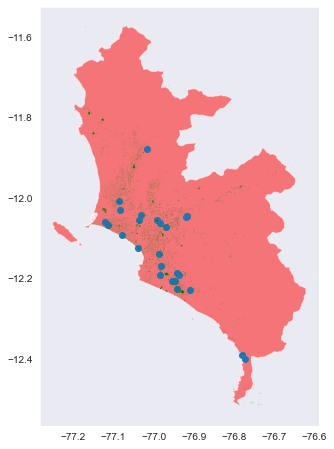

In [37]:
# Visualizar los daots para verificarlos
print('Leisure puntos:', leisure_nodes_gdf.shape[0])
print('Leisure poligonos:', leisure_ways_gdf.shape[0])
ax = lima_metropolitana.plot(color='red', alpha=0.5, figsize=(5,75))
leisure_nodes_gdf.plot(ax=ax)
leisure_ways_gdf.plot(ax=ax, linewidth=0, color='green')
plt.show()

## Procesamiento 
Se utilizará la librería [H3](https://h3geo.org/) de Uber para implementar un sistema de grillas que facilite la unificación de capas de datos geo-espaciales

In [38]:
resolution = 8

# Polyfill the city boundaries
h3_centroids = list()
h3_polygons = list()
h3_indexes = list()

lima_polygons = lima_metropolitana.explode().reset_index(drop=True) # Get every polygon in Multipolygon shape

for ix, geo in lima_polygons.iterrows():
    hexagons = h3.polyfill(geo[0].__geo_interface__, res=resolution, geo_json_conformant=True)
    for hexagon in hexagons:
        centroid_lat, centroid_lon = h3.h3_to_geo(hexagon) # format as x,y (lon, lat)
        h3_centroids.append(shapely.geometry.Point(centroid_lon, centroid_lat))
        
        h3_geo_boundary = h3.h3_to_geo_boundary(hexagon)
        [bound.reverse() for bound in h3_geo_boundary] # format as x,y (lon, lat)
        h3_polygons.append(shapely.geometry.Polygon(h3_geo_boundary))
        
        h3_indexes.append(hexagon)
        
# Create hexagon dataframe         
lima_metropolitana_h = gpd.GeoDataFrame(h3_indexes, geometry=h3_polygons).drop_duplicates()
lima_metropolitana_h.crs = 'EPSG:4326'
lima_metropolitana_centroids = gpd.GeoDataFrame(h3_indexes, geometry=h3_centroids).drop_duplicates()
lima_metropolitana_centroids.crs = 'EPSG:4326'

In [39]:
# Isla y la punta
isla_sl = lima_metropolitana_centroids.geometry.y.between(-12.2,-12) & lima_metropolitana_centroids.geometry.x.between(-100,-77)

# Solo isla
isla_sl_red = lima_metropolitana_centroids.geometry.y.between(-12.2,-12) & lima_metropolitana_centroids.geometry.x.between(-100,-77.17)

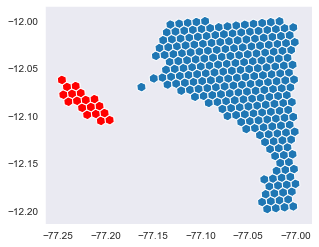

In [40]:
# Visualizar para validar
ax = lima_metropolitana_h[isla_sl].plot()
lima_metropolitana_h[isla_sl_red].plot(ax=ax, color='red')
plt.show()

In [41]:
# Eliminaremos los hexagonos que corresponden a la isla
drop_ix = lima_metropolitana_h[isla_sl_red].index
print(lima_metropolitana_h.shape)
lima_metropolitana_h = lima_metropolitana_h.drop(drop_ix)
lima_metropolitana_centroids = lima_metropolitana_centroids.drop(drop_ix)
print(lima_metropolitana_h.shape)

(3300, 2)
(3282, 2)


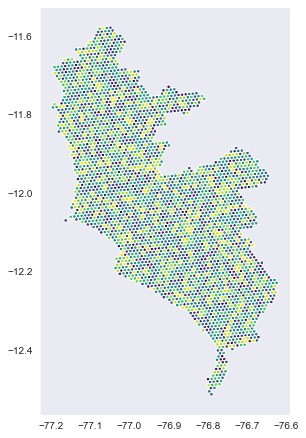

In [42]:
# Visualize result for sanity check 
lima_metropolitana_h.plot(cmap='viridis', figsize=(5,7.5))
plt.show()

### Población por hexágono

#### Poblacion total

In [43]:
# Spatial join entre puntos de poblacion y hexagonos
dfh_pop = gpd.tools.sjoin(
    left_df = population_lima_gdf,
    right_df = lima_metropolitana_h, 
    how = 'inner'
)

In [44]:
# Agregamos la variable poblacion a los datos de hexagonos
population_by_hex = dfh_pop.groupby('index_right')['population_2020'].sum()
lima_metropolitana_h.loc[population_by_hex.index, 'population_2020'] = population_by_hex.values

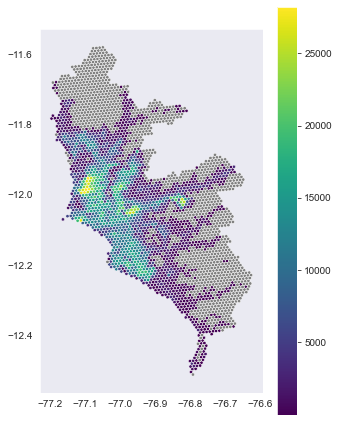

In [45]:
# Visualize results
lima_metropolitana_h.plot(
    column='population_2020', cmap='viridis',
    linewidth=0.5, legend=True, figsize=(5,7.5),
    missing_kwds={'color':'grey'})
plt.show()

#### Poblacion mayor a 60 años

In [46]:
# Spatial join entre puntos de población y hexágonos
dfh_pop_60 = gpd.tools.sjoin(
    left_df = population_over_60_lima_gdf,
    right_df = lima_metropolitana_h, 
    how = 'inner'
)

In [47]:
# Agregamos poblacion a los datos de hexagonos
population_over_60_by_hex = dfh_pop_60.groupby('index_right')['population'].sum()
lima_metropolitana_h.loc[population_over_60_by_hex.index, 'population_over_60'] = population_over_60_by_hex.values

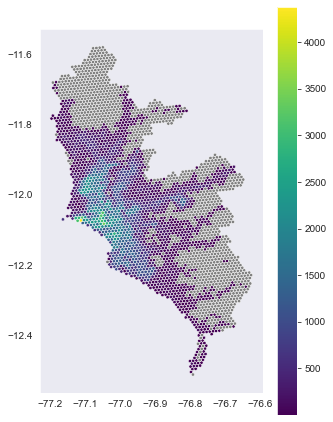

In [48]:
# Visualize results
lima_metropolitana_h.plot(
    column='population_over_60', cmap='viridis',
    linewidth=0.5, legend=True, figsize=(5,7.5),
    missing_kwds={'color':'grey'})
plt.show()

### Niveles socioconómicos por hexágono

In [49]:
# Separamos la variable NSE como one-hot (e.g [[0, 0, 1],[0, 1, 0]])
manzanas['NSE07'] = manzanas['NSE07'].fillna('missing')
nse_cat = pd.get_dummies(manzanas['NSE07'])
# Agregamos las columnas al dataframe original
manzanas = pd.concat((manzanas, nse_cat), axis=1)

In [50]:
# Seleccionamos las manazanas dentro de cada hexágono
dfh_nse = gpd.tools.sjoin(
    left_df = manzanas,
    right_df = lima_metropolitana_h, 
    op = 'within',
    how="inner"
)

Ahora vamos a calcular el porcentaje de manzanas por nivel socioeconómico en cada hexágono.
Para esto primero debemos calcular:

- Total de manzanas por hexagono

- Número de manzanas por nivelsocieconomico en cada hexagono

    **WARNING**: No se está considerando el área ni población de las manzanas (censada en el 2007).

In [51]:
# Total de manzanas por hexagono
manzanas_per_hexagon = dfh_nse.groupby('index_right').size()
manzanas_per_hexagon.name = "total_manzanas"

In [52]:
# Número de manzanas por nivelsocieconomico en cada hexagono
nse_per_hexagon = dfh_nse.groupby('index_right')[['missing','0.','AL','BA','MA','MB','ME']].sum()

In [53]:
# Porcentaje de manzanas por nivel socioeconomico en cada hexagono
nse_perc_per_hexagon = nse_per_hexagon.divide(manzanas_per_hexagon, axis='rows')

In [54]:
# Agregamos las columnas al GeoDataFrame de hexágonos
lima_metropolitana_h = pd.concat((lima_metropolitana_h, nse_perc_per_hexagon, manzanas_per_hexagon), axis=1)

En el siguiente gráfico vamos a visualizar **el porcentaje de manzanas de NSE Bajo** en cada hexágono

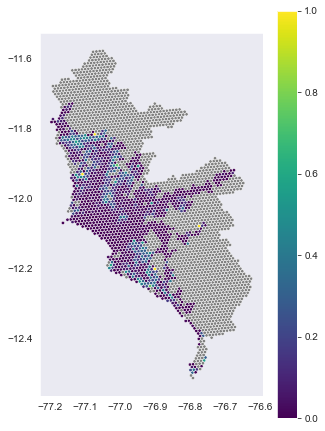

In [55]:
lima_metropolitana_h.plot(
    column='BA', 
    cmap='viridis', 
    linewidth=0.5, 
    legend=True, 
    figsize=(5,7.5), 
    missing_kwds={'color':'grey'})
plt.show()

### Instalación de alimentos más cercana a cada hexágono

In [56]:
# Create KDTree to search for spatial nearest neighboard
kdtree = cKDTree(data=food_access_pois_gdf[['lon','lat']].values)

**WARNING**  
        
        Buscar el punto más cercano con este método puede causar que el punto más cercano (linea recta) no sea el más cercano considerando las vías de la ciudad. Una alternativa interesante seria usar *isochrones* calculados desde cada instalacion y luego hacer una intersección con los hexágonos o las manzanas.

Primero se descartarán los hexagonos con una población mayor a 60 años menor a un umbral dado.

In [57]:
pob_treshold = 100

pob_filter = lima_metropolitana_h['population_over_60'] > pob_treshold
print(lima_metropolitana_centroids.shape)
lima_metropolitana_centroids = lima_metropolitana_centroids[pob_filter] # centroids
lima_metropolitana_h = lima_metropolitana_h[pob_filter] # hexagons
print(lima_metropolitana_centroids.shape)

(3282, 2)
(1087, 2)


Utilizaremos el centroide de cada hexágono como estimación de su posición para hacer la búsqueda.

In [58]:
# nn_ff: nearest_food_facility
lima_metropolitana_centroids.loc[:,'nn_ff'] = lima_metropolitana_centroids.geometry.progress_apply(lambda geom: kdtree.query([geom.x, geom.y])[1])

100%|██████████| 1087/1087 [00:00<00:00, 5370.45it/s]


Ahora vamos a calcular la duración y la distancia de un viaje caminando desde el centro de un hexágono hacia un lugar de compra de alimento, Fuente: [OSRM](http://project-osrm.org/).   

La instalación del software para la adquisición de la grilla de calles y puesta en marcha del servicio OSRM de ruteo se encuentra detallado en este [notebook](https://vulnerabilidad-codigo.netlify.com/).

In [59]:
def osrm_routes(origin, destination, profile):
    try:
        orig = f'{origin.x},{origin.y}'
        dest = f'{destination.x},{destination.y}'
        url = f'http://localhost:5000/route/v1/{profile}/{orig};{dest}' # Local osrm server
        response = requests.get(url, params={'overview': 'false'})
        data = response.json()['routes'][0]
        return [data['distance'], data['duration']]
    except Exception as err:
        print(err)
        print(response.reason)
        print(response.url)
        pass

In [60]:
# Distancia y duración del viaje a pie
lima_metropolitana_centroids[['dist_nn_ff_walk', 'dur_nn_ff_walk']] = lima_metropolitana_centroids.progress_apply(
    lambda row: osrm_routes(
        origin=row.geometry, 
        destination = food_access_pois_gdf.iloc[row['nn_ff']]['geometry'],
        profile = 'walking'
    ),
    result_type='expand',
    axis=1,
)

 29%|██▉       | 319/1087 [00:04<00:13, 55.01it/s]

'routes'
Bad Request
http://localhost:5000/route/v1/walking/-77.13559405230563,-12.012289716455555;-77.1286628,-11.9918824?overview=false


 54%|█████▍    | 590/1087 [00:07<00:05, 96.74it/s]

'routes'
Bad Request
http://localhost:5000/route/v1/walking/-77.13177599021921,-12.004048976393507;-77.1286628,-11.9918824?overview=false


 76%|███████▋  | 831/1087 [00:10<00:04, 60.75it/s] 

'routes'
Bad Request
http://localhost:5000/route/v1/walking/-77.13026416087776,-12.019634417015354;-77.1084532,-12.0237839?overview=false


100%|██████████| 1087/1087 [00:14<00:00, 74.37it/s]

'routes'
Bad Request
http://localhost:5000/route/v1/walking/-77.13408234546175,-12.027875110225208;-77.1084532,-12.0237839?overview=false
'routes'
Bad Request
http://localhost:5000/route/v1/walking/-77.13941236656875,-12.020530444594938;-77.1286628,-11.9918824?overview=false


In [61]:
# Check missing values
lima_metropolitana_centroids[['dist_nn_ff_walk']].isna().sum()

dist_nn_ff_walk    5
dtype: int64

In [62]:
# Check descriptive statistics
(lima_metropolitana_centroids[['dist_nn_ff_walk', 'dur_nn_ff_walk']] / [1000, 60]).describe()  # meters to km & seconds to hours

dist_nn_ff_walk  dur_nn_ff_walk
count      1082.000000     1082.000000
mean          3.118064       37.439994
std           9.092013      109.152256
min           0.007900        0.093333
25%           0.607150        7.298333
50%           1.290550       15.498333
75%           2.762375       33.143333
max         186.016600     2232.665000

In [63]:
# Trataremos los outliers outliers
outliers_top = lima_metropolitana_centroids['dur_nn_ff_walk'].quantile(0.9)
lima_metropolitana_centroids['dur_nn_ff_walk'] = lima_metropolitana_centroids['dur_nn_ff_walk'].clip(0,outliers_top)

outliers_top = lima_metropolitana_centroids['dist_nn_ff_walk'].quantile(0.9)
lima_metropolitana_centroids['dist_nn_ff_walk'] = lima_metropolitana_centroids['dist_nn_ff_walk'].clip(0,outliers_top)

In [64]:
# Agregar las columnas al GeoDataFrame hexágonos
lima_metropolitana_h.loc[lima_metropolitana_centroids.index,'dist_nn_ff_walk'] = lima_metropolitana_centroids['dist_nn_ff_walk'].values
lima_metropolitana_h.loc[lima_metropolitana_centroids.index,'dur_nn_ff_walk'] = lima_metropolitana_centroids['dur_nn_ff_walk'].values / 60 # seconds to minutes

In [65]:
lima_metropolitana_h['dur_nn_ff_walk'].describe()

count    1082.000000
mean       23.048891
std        20.391351
min         0.093333
25%         7.298333
50%        15.498333
75%        33.143333
max        65.960333
Name: dur_nn_ff_walk, dtype: float64

In [67]:
# Generamos cortes en la variable duración del viaje
lima_metropolitana_h['dur_nn_ff_walk_bins'] = pd.cut(
    lima_metropolitana_h['dur_nn_ff_walk'], 
    bins=[0, 15, 30, 45, 60, 90]
)

In [68]:
# Verificamos la cantidad de celdas por corte
lima_metropolitana_h['dur_nn_ff_walk_bins'].value_counts()

(0, 15]     530
(15, 30]    254
(60, 90]    134
(30, 45]    112
(45, 60]     52
Name: dur_nn_ff_walk_bins, dtype: int64

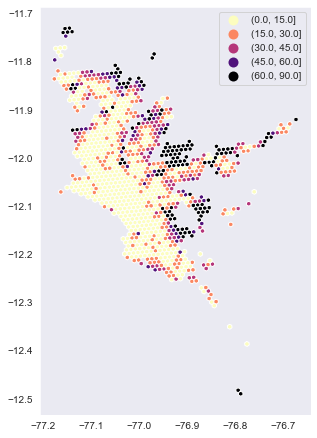

In [69]:
# Visualize results
lima_metropolitana_h.plot(
    column='dur_nn_ff_walk_bins', 
    cmap='magma_r',
    legend=True, 
    figsize=(5,7.5)
)
plt.show()

#### Centros de Salud mas cercanos a cada hexagono

In [70]:
# Creeamos un KDTree para buscar el vecino espacial más cercano
kdtree = cKDTree(data=health_sites_gdf[['lon','lat']].values)

In [71]:
# nn_hs: nearest_health_sites
lima_metropolitana_centroids.loc[:,'nn_hs'] = lima_metropolitana_centroids.geometry.progress_apply(lambda geom: kdtree.query([geom.x, geom.y])[1])

100%|██████████| 1087/1087 [00:00<00:00, 7666.66it/s]


In [72]:
# Distancia y duración del viaje a pie
lima_metropolitana_centroids[['dist_nn_hs_walk', 'dur_nn_hs_walk']] = lima_metropolitana_centroids.progress_apply(
    lambda row: osrm_routes(
        origin=row.geometry, 
        destination = health_sites_gdf.iloc[row['nn_hs']]['geometry'],
        profile = 'walking'
    ),
    result_type='expand',
    axis=1,
)

 30%|██▉       | 323/1087 [00:04<00:09, 77.12it/s]

'routes'
Bad Request
http://localhost:5000/route/v1/walking/-77.13559405230563,-12.012289716455555;-77.099196,-12.0056017?overview=false


 54%|█████▍    | 589/1087 [00:07<00:06, 76.70it/s]

'routes'
Bad Request
http://localhost:5000/route/v1/walking/-77.13177599021921,-12.004048976393507;-77.099196,-12.0056017?overview=false


 77%|███████▋  | 833/1087 [00:10<00:02, 87.84it/s]

'routes'
Bad Request
http://localhost:5000/route/v1/walking/-77.13026416087776,-12.019634417015354;-77.097839,-12.0183988?overview=false


100%|█████████▉| 1086/1087 [00:13<00:00, 86.59it/s]

'routes'
Bad Request
http://localhost:5000/route/v1/walking/-77.13408234546175,-12.027875110225208;-77.1197439,-12.0538348?overview=false
'routes'
Bad Request
http://localhost:5000/route/v1/walking/-77.13941236656875,-12.020530444594938;-77.1197439,-12.0538348?overview=false


100%|██████████| 1087/1087 [00:13<00:00, 79.66it/s]


In [73]:
# Trataremos los outliers outliers
outliers_top = lima_metropolitana_centroids['dur_nn_hs_walk'].quantile(0.9)
lima_metropolitana_centroids['dur_nn_hs_walk'] = lima_metropolitana_centroids['dur_nn_hs_walk'].clip(0,outliers_top)

outliers_top = lima_metropolitana_centroids['dist_nn_hs_walk'].quantile(0.9)
lima_metropolitana_centroids['dist_nn_hs_walk'] = lima_metropolitana_centroids['dist_nn_hs_walk'].clip(0,outliers_top)

In [74]:
# Add values to hexagons GeoDataFrame
lima_metropolitana_h.loc[lima_metropolitana_centroids.index,'dist_nn_hs_walk'] = lima_metropolitana_centroids['dist_nn_hs_walk'].values
lima_metropolitana_h.loc[lima_metropolitana_centroids.index,'dur_nn_hs_walk'] = lima_metropolitana_centroids['dur_nn_hs_walk'].values / 60 # seconds to minutes

In [75]:
lima_metropolitana_h['dur_nn_hs_walk'].describe()

count    1082.000000
mean       32.257096
std        27.601681
min         0.000000
25%        10.938333
50%        21.617500
75%        45.662083
max        89.736000
Name: dur_nn_hs_walk, dtype: float64

In [76]:
# Generamos cortes en la variable duración del viaje
lima_metropolitana_h['dur_nn_hs_walk_bins'] = pd.cut(
    lima_metropolitana_h['dur_nn_hs_walk'], 
    bins = [0, 15, 30, 45, 60, 90]
)

In [77]:
# Verificamos la cantidad de celdas por corte
lima_metropolitana_h['dur_nn_hs_walk_bins'].value_counts()

(0, 15]     402
(15, 30]    265
(60, 90]    202
(30, 45]    132
(45, 60]     80
Name: dur_nn_hs_walk_bins, dtype: int64

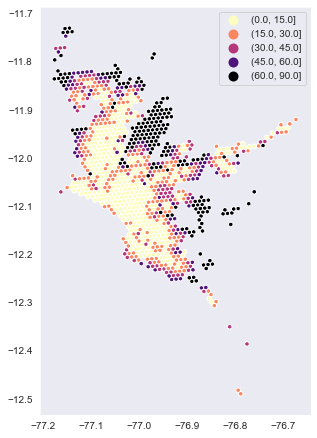

In [78]:
# Visualize results
lima_metropolitana_h.plot(
    column='dur_nn_hs_walk_bins', 
    cmap='magma_r',
    legend=True, 
    figsize=(5,7.5)
)
plt.show()

## Identificación de zonas de riesgo

#### Acceso a centros de salud

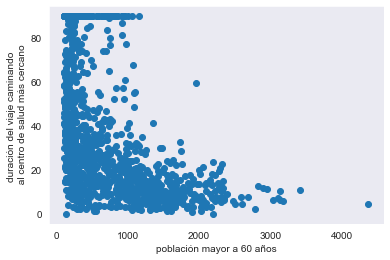

In [79]:
fig = plt.scatter(
    x = lima_metropolitana_h['population_over_60'],
    y = lima_metropolitana_h['dur_nn_hs_walk'],
)
plt.xlabel('población mayor a 60 años')
plt.ylabel('duración del viaje caminando \n al centro de salud más cercano')
plt.show()

Sobre la base del gráfico, consideraremos **población vulnerable** a quienes tienen una población (personas de 60 años o más) mayor a de 500 y tengan una **duración de viajea a un centro de salud mayor a 25 minutos**, respectivamente.

# hexagonos:  66


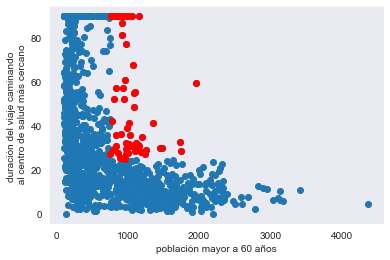

In [80]:
plt.scatter(
    x = lima_metropolitana_h['population_over_60'],
    y = lima_metropolitana_h['dur_nn_hs_walk'],
)

# Filtro de poblacion vulnerable 
pob_min = 750
dur_min = 25
filtro_pob_vulnerable = (lima_metropolitana_h['population_over_60'] > pob_min) & (lima_metropolitana_h['dur_nn_hs_walk'] > dur_min)
print('# hexagonos: ', filtro_pob_vulnerable.sum())

plt.scatter(
    x = lima_metropolitana_h[filtro_pob_vulnerable]['population_over_60'],
    y = lima_metropolitana_h[filtro_pob_vulnerable]['dur_nn_hs_walk'],
    color = 'red'
)

plt.xlabel('población mayor a 60 años')
plt.ylabel('duración del viaje caminando \n al centro de salud más cercano')
plt.show()

Ahora si colocamos los resultados en un mapa

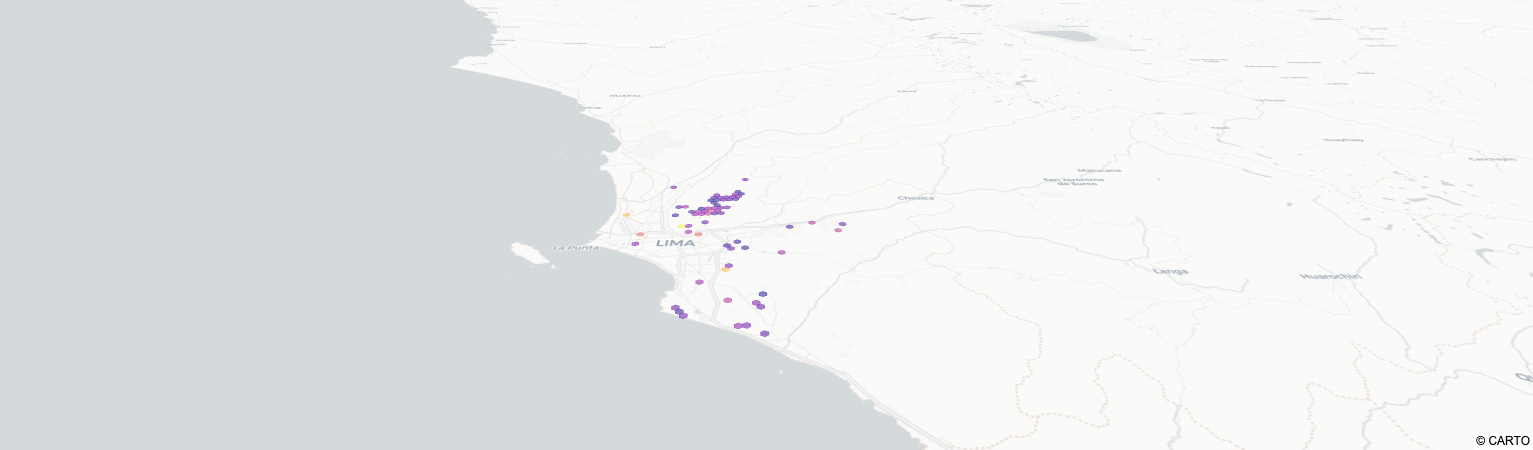

In [81]:
fig = go.Figure(
    go.Choroplethmapbox(
        geojson=lima_metropolitana_h[['geometry']].__geo_interface__,
        locations=lima_metropolitana_h[filtro_pob_vulnerable].index.values.tolist(),
        #z=np.ones(shape=lima_metropolitana_h.shape[0]), # Just one color
        z=lima_metropolitana_h[filtro_pob_vulnerable]['population_over_60'].values.tolist(),
        showscale=False,
        marker_opacity=0.5,
        marker_line_width=0,
    )
)
fig.update_layout(
    mapbox_style="carto-positron", 
    mapbox_zoom=9, 
    mapbox_pitch=60, 
    mapbox_bearing=0, 
    mapbox_center = {"lat": lima_metropolitana.centroid.y[0], 
                     "lon": lima_metropolitana.centroid.x[0]})

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#### Acceso a instalaciones de oferta alimentaria

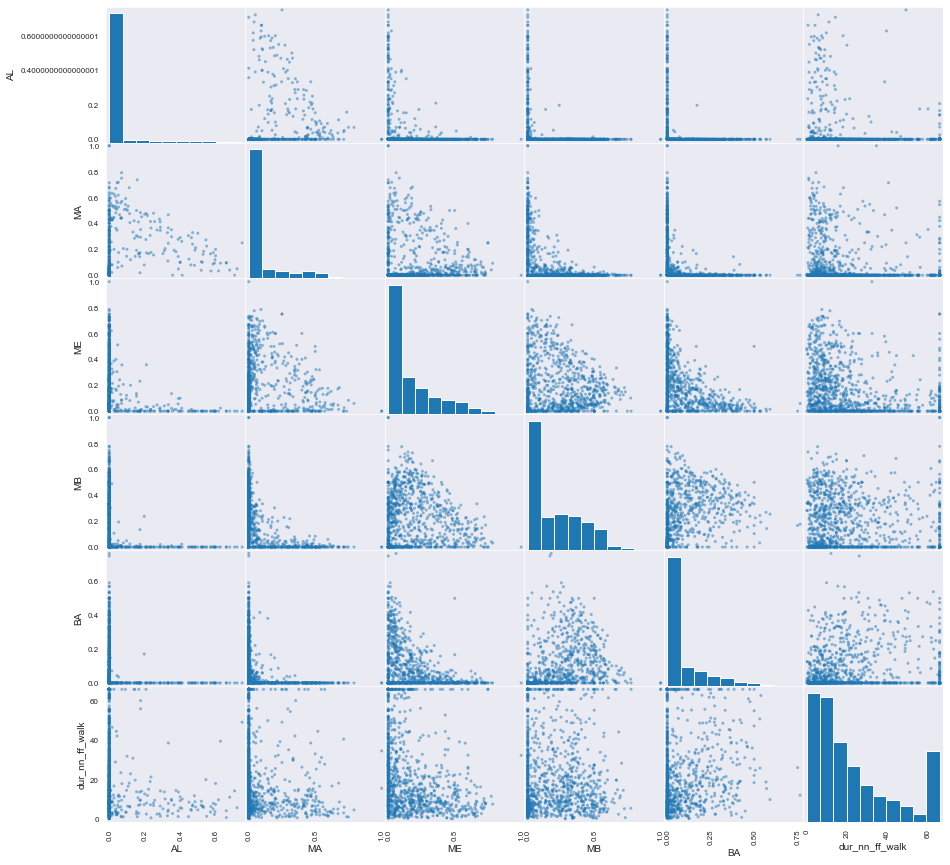

In [82]:
pd.plotting.scatter_matrix(lima_metropolitana_h[['AL','MA','ME','MB','BA','dur_nn_ff_walk']], figsize=(15,15)) # CAMBIAR DE PLOT: 1 ROW vs 5 COLUMNS SEABORN
plt.show()

Sobre la base de los gráficos consideraremos **población en riesgo** dentro de los hexágonos que tengan:

- Más de 50% de manzanas en el **nivel socioeconómico medio bajo (MB) o bajo (BA)**
- Una **duración del viaje hacia la instalación de alimentos más cercana mayor a 30 minutos**

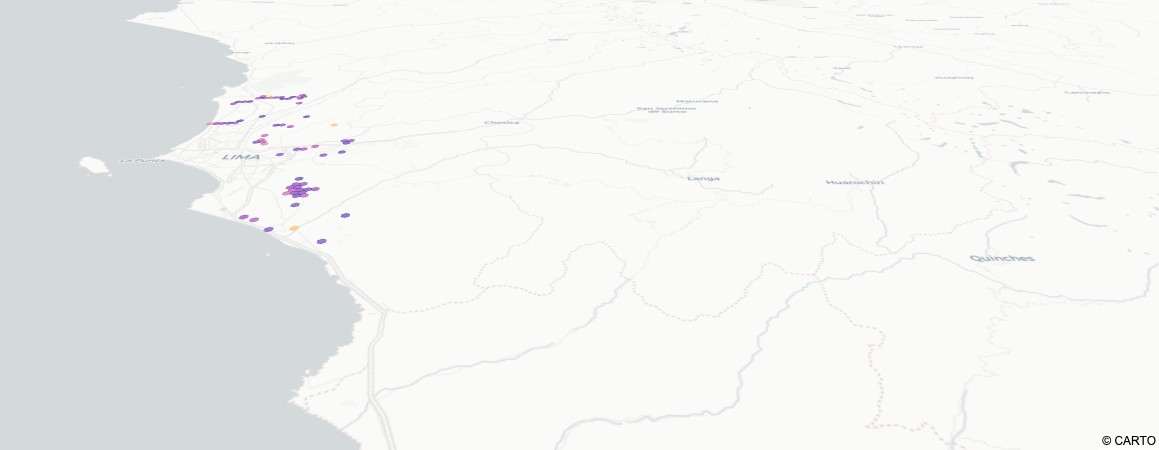

In [83]:
filtro_pob_en_riesgo = ((lima_metropolitana_h['MB'] + lima_metropolitana_h['BA']) > 0.5) & (lima_metropolitana_h['dur_nn_ff_walk'] > 30)

fig = go.Figure(
    go.Choroplethmapbox(
        geojson=lima_metropolitana_h[['geometry']].__geo_interface__,
        locations=lima_metropolitana_h[filtro_pob_en_riesgo].index.values.tolist(),
        #z=np.ones(shape=lima_metropolitana_h.shape[0]), # Just one color
        z=lima_metropolitana_h[filtro_pob_vulnerable]['population_over_60'].values.tolist(),
        showscale=False,
        marker_opacity=0.5,
        marker_line_width=0,
    )
)
fig.update_layout(
    mapbox_style="carto-positron", 
    mapbox_zoom=9, 
    mapbox_pitch=60, 
    mapbox_bearing=0, 
    mapbox_center = {"lat": lima_metropolitana.centroid.y[0], 
                     "lon": lima_metropolitana.centroid.x[0]})

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#### Prueba de mapas 3D

In [84]:
# Opciones de iconos
ICON_HEIGHT = 128
ICON_WIDTH = 128

icon_data = {
    'clinic': {
        "url": "https://img.icons8.com/office/80/000000/clinic.png",
        "width": ICON_HEIGHT,
        "height": ICON_WIDTH,
    },
    'hospital': {
        "url": "https://img.icons8.com/office/80/000000/hospital-2.png",
        "width": ICON_HEIGHT,
        "height": ICON_WIDTH,
    },
    'pharmacy': {
        "url":  "https://img.icons8.com/office/80/000000/prescription-pill-bottle.png",
        "width": ICON_HEIGHT,
        "height": ICON_WIDTH,
    },
    'market_place': {
        "url": "https://img.icons8.com/office/80/000000/shopping-basket.png",
        "width": ICON_HEIGHT,
        "height": ICON_WIDTH,
    },
    'supermarket': {
        "url": "https://img.icons8.com/office/80/000000/shopping-cart.png",
        "width": ICON_HEIGHT,
        "height": ICON_WIDTH,
    },
    'kiosk': {
        "url":  "https://img.icons8.com/office/80/000000/small-business.png",
         "width": ICON_HEIGHT,
        "height": ICON_WIDTH,
    },
    'mall': {
        "url":  "https://img.icons8.com/office/80/000000/shopping-bag.png",
        "width": ICON_HEIGHT,
        "height": ICON_WIDTH,
    },
    'convenience': {
        "url":  "https://img.icons8.com/office/80/000000/shop.png",
        "width": ICON_HEIGHT,
        "height": ICON_WIDTH,
    },
    'butcher': {
        "url":  "https://img.icons8.com/office/80/000000/rack-of-lamb.png",
        "width": ICON_HEIGHT,
        "height": ICON_WIDTH,
    },
    'greengrocer': {
        "url":  "https://img.icons8.com/office/80/000000/ingredients.png",
        "width": ICON_HEIGHT,
        "height": ICON_WIDTH,
    },    
    'pitch': {
        "url": "https://img.icons8.com/office/80/000000/soccer-goal.png",
        "width": ICON_HEIGHT,
        "height": ICON_WIDTH,
    },
    'park': {
        "url": "https://img.icons8.com/office/80/000000/grass.png",
        "width": ICON_HEIGHT,
        "height": ICON_WIDTH,
    }
}

##### Poblacion mayor a 60 y Distancia a un centro medico 

In [134]:
lima_metropolitana_h['hex'] = lima_metropolitana_h[0] # rename column for readability
# Seleccionamos las variables relevantes
selected_features = ['hex', 'population_over_60', 'dist_nn_hs_walk', 'dur_nn_hs_walk', 'dur_nn_hs_walk_bins']
hex_hs_data = lima_metropolitana_h[selected_features].reset_index(drop=True)

In [135]:
# Codificaremos los bins de duracion del viaje hacia un punto de venta de alimentos
bins_labels = hex_hs_data['dur_nn_hs_walk_bins'].unique().categories.values
bins_replace = {label: i  for i, label in enumerate(bins_labels)}
hex_hs_data['count'] = hex_hs_data['dur_nn_hs_walk_bins'].replace(bins_replace)

In [136]:
hex_hs_data['count'].value_counts()

0.0    402
1.0    265
4.0    202
2.0    132
3.0     80
Name: count, dtype: int64

In [137]:
# Label para la leyenda
human_readable_labels_60hs = [f"{x.left:0.0f}' a {x.right:0.0f}'" for x in bins_labels]

In [138]:
human_readable_labels_60hs

["0' a 15'", "15' a 30'", "30' a 45'", "45' a 60'", "60' a 90'"]

In [139]:
# Colores para cada hexagono segun su categoria
cmap = plt.get_cmap(name='viridis')
cmap_ixs = [int(round(255 / (i+1))) for i in hex_hs_data['count'].fillna(0).values]
rgb_values = [[color * 255 for color in cmap.colors[cmap_ix]] for cmap_ix in cmap_ixs]
rgb_count_df = pd.DataFrame(rgb_values, columns=['r','g','b'])

# Agregamos las variables del color RBG para usarlo como variableas en pydeck
hex_hs_data_colors = pd.concat((hex_hs_data, rgb_count_df), axis=1) 

In [140]:
for i in range(5):
    print(hex_hs_data_colors[hex_hs_data_colors['count'] == i].iloc[0,-3:])

r    253.278
g     231.07
b    36.7037
Name: 0, dtype: object
r    32.5298
g    144.572
b    140.392
Name: 3, dtype: object
r    48.6109
g    103.801
b    141.803
Name: 1, dtype: object
r    58.5834
g    82.2021
b    139.155
Name: 19, dtype: object
r    64.7534
g    67.6398
b    135.146
Name: 14, dtype: object


In [141]:
# Eliminamos esta variable (Intervalos) para evitar problemas de compatibilidad
hex_hs_data_colors = hex_hs_data_colors.drop('dur_nn_hs_walk_bins', axis=1)

In [142]:
# Le damos formato para que se pueda leer la informacion en "hover"
hex_hs_data_colors['population_over_60'] = hex_hs_data_colors['population_over_60'].round()
hex_hs_data_colors['dur_nn_hs_walk'] = hex_hs_data_colors['dur_nn_hs_walk'].round(2)

In [143]:
# Almacenamos los datos para este mapa
hex_hs_data_colors.to_csv('outputs/pop_over_60_hs_bins.csv')

In [144]:
# verificamos 
hex_hs_data_colors.isna().sum()

hex                   0
population_over_60    0
dist_nn_hs_walk       5
dur_nn_hs_walk        5
count                 6
r                     0
g                     0
b                     0
dtype: int64

In [145]:
# Debes crear una cuenta en mapbox y obtener tu api key para usar los basemaps
from mapboxkey import MAPBOX_API_KEY

In [146]:
hs_data = health_sites_gdf.copy()
hs_data["icon_data"] = None
hs_data["info"] = None
for index, row in hs_data.iterrows():
    tags = row['tags']
    # Agrega el icono correspondiente
    hs_data["icon_data"][index] = icon_data[tags['amenity']]
    # Agrega la información del punto
    hs_data["info"][index] = ''.join([f'<b>{key}</b>: {val}<br>' for key, val in tags.items()])

/Users/cortega/Documents/COVID-19/VulnerabilityMaps_LimaLab_BID/.env/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/cortega/Documents/COVID-19/VulnerabilityMaps_LimaLab_BID/.env/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [148]:
# Define a layers to display on a map
icon_layer = pdk.Layer(
    type="IconLayer",
    data=hs_data[['type', 'id', 'lat', 'lon', 'info', 'icon_data']],
    get_icon="icon_data",
    size_scale=30,
    get_position=["lon", "lat"],
    pickable=True,
)


layer = pdk.Layer(
    "H3HexagonLayer",
    hex_hs_data_colors,
    pickable=True,
    stroked=False,
    material=True,
    filled=True,
    extruded=True,
    elevation_scale=0.15,
    opacity=0.2,
    get_hexagon="hex",
    get_elevation="population_over_60",
    get_fill_color="[r, g, b]",
    get_line_color=[0, 0, 0],
    line_width_min_pixels=0,
)

# Set the viewport location
view_state = pdk.ViewState(
    latitude=-12.1,
    longitude=-77, 
    zoom=10, 
    bearing=0, 
    pitch=45)

tooltip = """
<b>HEX info</b>:<br>
<b>Distancia</b>: {dist_nn_hs_walk} metros <br>
<b>Duración</b>: {dur_nn_hs_walk} minutos <br>
<b>Población mayor de 60</b>: {population_over_60} <br>
--------------------------------- <br>
<b>POI info</b>:<br>
{info}
"""


# Render
r = pdk.Deck(layers=[icon_layer, layer], initial_view_state=view_state, tooltip={"html":tooltip}, 
             map_style='mapbox://styles/havb/ck8ajsl0t14m01ipfoizwegja', mapbox_key=MAPBOX_API_KEY)
r.to_html("h3_hexagon_layer_health_sites.html")

'/Users/cortega/Documents/COVID-19/VulnerabilityMaps_LimaLab_BID/h3_hexagon_layer_health_sites.html'

##### Poblacion estimada 2020 y Oferta alimentaria

In [149]:
selected_features = ['hex', 'population_2020', 'dur_nn_ff_walk_bins', 'dur_nn_ff_walk']
data_ff = lima_metropolitana_h[selected_features].reset_index(drop=True)

In [150]:
# Codificaremos los bins de duracion del viaje hacia un punto de venta de alimentos
bins_labels = data_ff['dur_nn_ff_walk_bins'].unique().categories.values
bins_replace = {label: i  for i, label in enumerate(bins_labels)}
data_ff['count'] = data_ff['dur_nn_ff_walk_bins'].replace(bins_replace)

In [151]:
bins_labels

<IntervalArray>
[(0, 15], (15, 30], (30, 45], (45, 60], (60, 90]]
Length: 5, closed: right, dtype: interval[int64]

In [152]:
data_ff['count'].value_counts()

0.0    530
1.0    254
4.0    134
2.0    112
3.0     52
Name: count, dtype: int64

In [153]:
# Label para la leyenda
human_readable_labels = [f"{x.left:0.0f}' a {x.right:0.0f}'" for x in bins_labels]

In [154]:
human_readable_labels

["0' a 15'", "15' a 30'", "30' a 45'", "45' a 60'", "60' a 90'"]

In [155]:
# Colores para cada hexagono segun su categoria
cmap = plt.get_cmap(name='magma')
cmap_ixs = [int(round(255 / (i+1))) for i in data_ff['count'].fillna(0).values]
rgb_values = [[color * 255 for color in cmap.colors[cmap_ix]] for cmap_ix in cmap_ixs]
rgb_count_df = pd.DataFrame(rgb_values, columns=['r','g','b'])

# Agregamos las variables del color RBG para usarlo como variableas en pydeck
data_with_colors_ff = pd.concat((data_ff, rgb_count_df), axis=1)

In [156]:
for i in range(5):
    print(data_with_colors_ff[data_with_colors_ff['count'] == i].iloc[0, -3:])

r    251.699
g    252.817
b    191.124
Name: 0, dtype: object
r    182.679
g    54.8204
b    121.199
Name: 13, dtype: object
r    113.517
g    31.2946
b     129.26
Name: 1, dtype: object
r    80.7468
g     18.281
b    123.772
Name: 11, dtype: object
r    59.1796
g    15.2717
b    111.612
Name: 2, dtype: object


In [157]:
# Eliminamos esta variable (Intervalos) para evitar problemas de compatibilidad
data_with_colors_ff = data_with_colors_ff.drop('dur_nn_ff_walk_bins', axis=1)

In [158]:
# Verificamos la poblacion para corregir la escala de elevacion
data_ff['population_2020'].describe()

count     1087.000000
mean      9358.522895
std       5756.651987
min       1049.831330
25%       4493.062400
50%       8484.988461
75%      13174.222734
max      28189.803973
Name: population_2020, dtype: float64

In [159]:
# Le damos formato para que se pueda leer la informacion en "hover"
data_with_colors_ff['population_2020'] = data_with_colors_ff['population_2020'].round()
data_with_colors_ff['dur_nn_ff_walk'] = data_with_colors_ff['dur_nn_ff_walk'].round(2)

In [160]:
# Almacenamos los datos para este mapa
data_with_colors_ff.to_csv('outputs/pop_food_access.csv')

In [161]:
ff_poi_data = food_access_pois_gdf.copy()
ff_poi_data["icon_data"] = None
ff_poi_data["info"] = None
for index, row in ff_poi_data.iterrows():
    tags = row['tags']
    if 'shop' in tags.keys():
        ff_poi_data["icon_data"][index] = icon_data[tags['shop']]
    elif 'amenity' in tags.keys():
        ff_poi_data["icon_data"][index] = icon_data[tags['shop']]
        
    ff_poi_data.loc[index, "info"] = ''.join([f'<b>{key}</b>: {val}<br>' for key, val in tags.items()])

/Users/cortega/Documents/COVID-19/VulnerabilityMaps_LimaLab_BID/.env/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [162]:
# Colocaremos la latitud y longitud en el orden necesario para pydeck (lat, lon)
def reverse_shell(shell):
    reversed_shell = []
    for val in shell:
        reversed_shell.append([val[1], val[0]])
    return reversed_shell

leisure_ways_gdf['reversed_shell'] =leisure_ways_gdf['shell'].apply(reverse_shell)

# Dar formato a la informacion en los tags
leisure_ways_gdf["info"] = None
for index, row in leisure_ways_gdf.iterrows():
    tags = row['tags']
    leisure_ways_gdf["info"][index] = ''.join([f'<b>{key}</b>: {val}<br>' for key, val in tags.items()])

/Users/cortega/Documents/COVID-19/VulnerabilityMaps_LimaLab_BID/.env/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [163]:
leisure_nodes_data = leisure_nodes_gdf.copy()
leisure_nodes_data["icon_data"] = None
leisure_nodes_data["info"] = None
for index, row in leisure_nodes_data.iterrows():
    tags = row['tags']
    leisure_nodes_data["icon_data"][index] = icon_data[tags['leisure']]
    leisure_nodes_data.loc[index, "info"] = ''.join([f'<b>{key}</b>: {val}<br>' for key, val in tags.items()])

/Users/cortega/Documents/COVID-19/VulnerabilityMaps_LimaLab_BID/.env/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [168]:
# Define a layers to display on a map
ff_icon_layer = pdk.Layer(
    type="IconLayer",
    data=ff_poi_data[['type', 'id', 'lat', 'lon', 'tags', 'icon_data', 'info']],
    get_icon="icon_data",
    size_scale=20,
    get_position=["lon", "lat"],
    pickable=True,
)

leisure_icon_layer = pdk.Layer(
    type="IconLayer",
    data=leisure_nodes_data[['type', 'id', 'lat', 'lon', 'info', 'icon_data']],
    get_icon="icon_data",
    size_scale=20,
    get_position=["lon", "lat"],
    pickable=True,
)

leisure_polygon_layer = pdk.Layer(
    "PolygonLayer",
    leisure_ways_gdf[['shell', 'info']],
    opacity=0.2,
    stroked=True,
    filled=True,
    pickable=True,
    get_polygon="shell",
    get_fill_color=[0, 255, 0],
)

layer = pdk.Layer(
    "H3HexagonLayer",
    data_with_colors_ff,
    pickable=True,
    stroked=False,
    material=True,
    filled=True,
    extruded=True,
    elevation_scale=0.05,
    opacity=0.2,
    get_hexagon="hex",
    get_elevation="population_2020",
    get_fill_color="[r, g, b]",
    get_line_color=[255, 255, 255],
    line_width_min_pixels=0,
)

# Set the viewport location
view_state = pdk.ViewState(
    latitude=-12.1,
    longitude=-77, 
    zoom=10, 
    bearing=0, 
    pitch=45
)

# Render
tooltip = {"html": 
"""
<b>HEX info</b>:<br>
<b>Distancia</b>: {dist_nn_ff_walk} metros <br>
<b>Duración</b>: {dur_nn_ff_walk} minutos <br>
<b>Población</b>: {population_2020} <br>
--------------------------------- <br>
<b>POI info</b>:<br>
{info}
"""
}

r = pdk.Deck(
    layers=[leisure_polygon_layer, leisure_icon_layer, ff_icon_layer, layer], 
    initial_view_state=view_state, tooltip=tooltip,
    map_style='mapbox://styles/havb/ck8ajsl0t14m01ipfoizwegja', 
    mapbox_key=MAPBOX_API_KEY
)
r.to_html("h3_hexagon_layer_foodaccess.html")

'/Users/cortega/Documents/COVID-19/VulnerabilityMaps_LimaLab_BID/h3_hexagon_layer_foodaccess.html'